## «Модель прогнозирования стоимости жилья для агентства недвижимости»

### 1. Знакомство с данными.

In [225]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import re
import optuna
import xgboost as xgb
from catboost import CatBoostRegressor
from statsmodels.graphics.gofplots import qqplot
import squarify

In [176]:
# загружаем занные
data = pd.read_csv('data/data_real_property.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);

➔ 'target' — цена объекта недвижимости (целевой признак).

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [178]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


В представленном датасете данные о  блее чем 300 000 объектов недвижимости и 18 их характеристик, все признаки имеют тип данных object. 

### 2. Очистка данных - обработка пропусков и дубликатов.

Признаки MlsId и mls-id являются идентификаторами, которые никак не влияют на цену недвижимости, удалим их.

In [179]:
data = data.drop(['MlsId', 'mls-id'], axis = 1)

Посмотрим на наличие пропусков в данных.

In [180]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
print(cols_with_null)

private pool    98.891525
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64


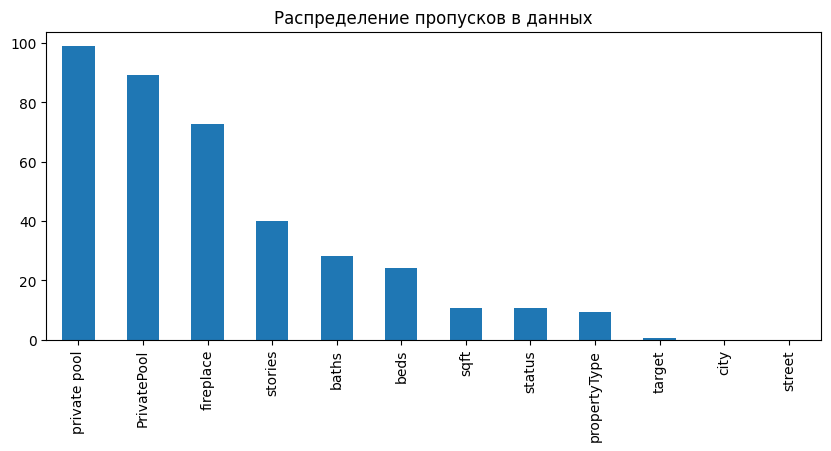

In [181]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

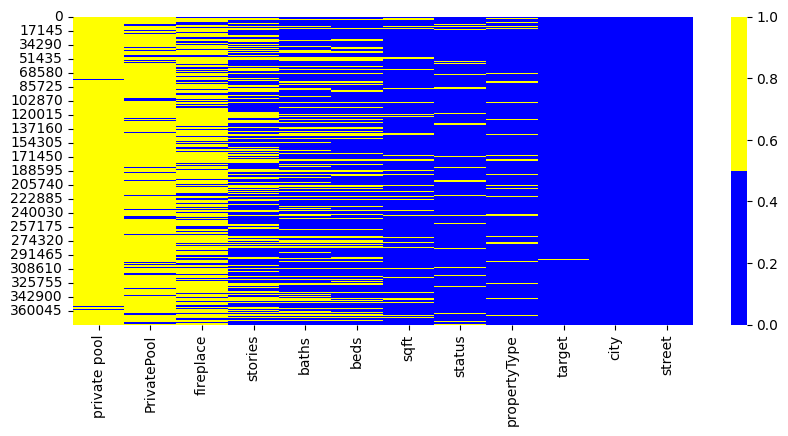

In [182]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

Очевидно, что три признака - private pool, PrivatePool, fireplace - имеют очень большое количество пропусков (более 70%). Кроме того, признаки private pool и PrivatePool несут одинаковую информацию о наличии бассейна, но даже объединив эти данные, доля пропусков все равно будет велика и их замена может исказить данные. Поэтмоу, несмотря на то, что наличие бассейна или камина могут оказывать влияние на стоимость недвижимости, эти данные придется удалить, так как восстановить их не представляется возможным.

In [183]:
# удалим все столбцы с пропусками более 40%
data = data.dropna(thresh=data.shape[0]*0.6, axis=1)

In [184]:
# найдем и удалим дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')
sber_dedupped = data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Число найденных дубликатов: 141
Результирующее число записей: 377044


Проверим данные на неинформативные признаки, которые не играют роли при моделировании и лишь засоряют таблицу, увеличивая объем данных. Найдем признаки, в которых:
- 95% строк содержат одинаковые значения
- 95% строк содержат уникальные значения 

In [185]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')
    else:
        print(f'{col} не является неинформативным признаком')

status не является неинформативным признаком
propertyType не является неинформативным признаком
street не является неинформативным признаком
baths не является неинформативным признаком
homeFacts не является неинформативным признаком
city не является неинформативным признаком
schools не является неинформативным признаком
sqft не является неинформативным признаком
zipcode не является неинформативным признаком
beds не является неинформативным признаком
state не является неинформативным признаком
stories не является неинформативным признаком
target не является неинформативным признаком


### 3. Преобразование данных и EDA.

Исследуем и преобразуем каждый признак.

Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении стимости недвижимости.

#### 3.1 Целевой признак - target.

In [186]:
# выведем статистику
data['target'].describe()

count       374704
unique       43939
top       $225,000
freq          1462
Name: target, dtype: object

In [187]:
# посмотрим на распределение
data['target'].value_counts().nlargest(15)

target
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
$375,000    1163
$450,000    1141
$499,000    1099
$175,000    1096
$425,000    1075
Name: count, dtype: int64

Признак имеет большое количество уникальных значение, что неудивительно, так как цена всегда индивидуальна для каждого объекта. 

- Проверим признак на пропуски и удалим их, так как это целевой признак, а значит строк с пропусками в нем быть не должно. 
- Проверим признак на специфические данные (возможно есть данные, не отвечающие сути признака)
- Переведем признак в тип данных float.
- Проверим и избавимся, если нужно от выбросов.

In [188]:
data['target'].isnull().mean()*100

0.6577674085660883

In [189]:
data = data.dropna(subset=['target'])

In [190]:
data[data.target.str.contains('/mo',regex=True)]

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,target
547,for rent,single-family home,4323 N Central Park Ave,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...","3,300 sqft",60618,4 Beds,IL,NaN,"$5,500/mo"
609,for rent,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,"$10,500/mo"
2075,for rent,single-family home,2830 NE 56th Ct,4 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...","2,400 sqft",33308,4 Beds,FL,NaN,"$6,390/mo"
3025,for rent,multi-family,411 Kline Aly,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...","1,280 sqft",37040,2 Beds,TN,NaN,"$1,200/mo"
3645,for rent,multi-family,240 E Illinois St #2011,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...","1,473 sqft",60611,2 Beds,IL,NaN,"$3,600/mo"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
371791,for rent,multi-family,9436 Turrentine Dr,1.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",El Paso,"[{'rating': ['4/10', '8/10', '6/10'], 'data': ...","1,050 sqft",79925,2 Beds,TX,NaN,$890/mo
372459,for rent,townhouse,34 Jonquil Pl,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",The Woodlands,"[{'rating': ['5/10', '8/10', '7/10', '8/10'], ...","2,601 sqft",77375,3 Beds,TX,NaN,"$2,500/mo"
374288,for rent,single-family home,8864 Devonshire Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Fort Worth,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,000 sqft",76131,4 Beds,TX,NaN,"$2,000/mo"
375550,for rent,townhouse,2217 W Seybert St,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720 sqft,19121,2 Beds,PA,NaN,"$1,500/mo"


В данных есть объекты, предназначенные для аренды, они имеют стоимость за месяц. Такие данных нужно удалить, чтобы не было путаницы между продажей и арендой.

In [191]:
data = data.drop(data[data['status'] == 'for rent'].index)

In [192]:
# удалим ненужные символы и переведем в тип данных float
data['target'] = data['target'].apply(lambda x: str(x).replace('$', '').replace(',', '').replace(' ', '').replace('+', '')).astype(float)

Text(0.5, 1.0, 'Целевой признак до удаления выбросов')

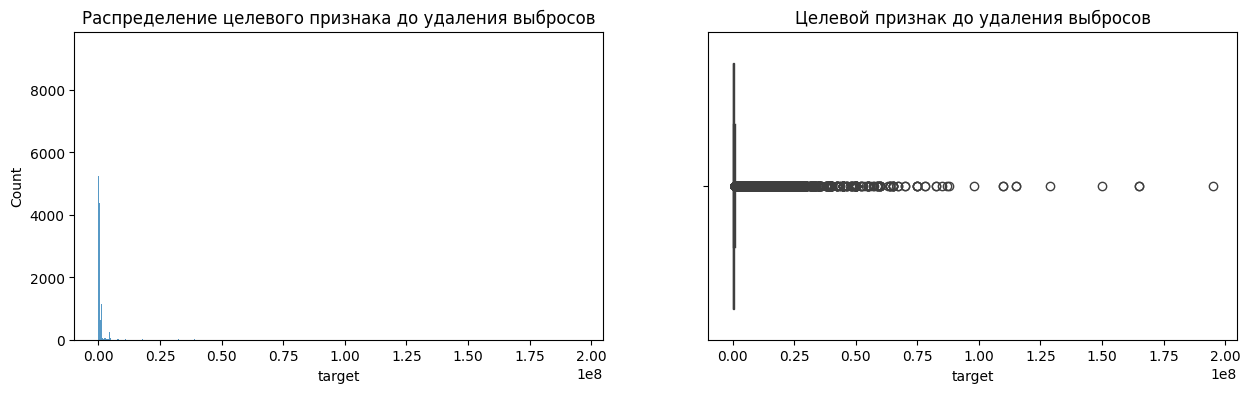

In [193]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = data, x = 'target', ax = axes[0]);
histplot.set_title('Распределение целевого признака до удаления выбросов')
boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
boxplot.set_title('Целевой признак до удаления выбросов')

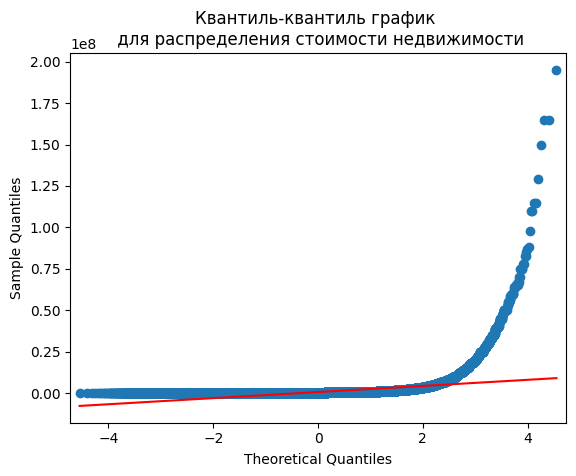

In [194]:
qqplot(data.target, line='s')
plt.title('Квантиль-квантиль график \n для распределения стоимости недвижимости')
plt.show()

Визуально распределение целевого признака не выглядит нормально. Проверим эту гипотезу с помощью статистического теста Д’Агостино (так как данных более 5000). 

H0 = 'Данные распределены нормально'

H1 = 'Данные не распределены нормально (мы отклоняем H0)'

Значение альфа - 0.5

In [195]:
alpha=0.5
_,p = stats.normaltest(data['target'])
print('p-value = %.3f'%(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.1f}. Распределение отлично от нормального'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.1f}. Распределение является нормальным'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.5. Распределение отлично от нормального


In [196]:
def outliers_z_score(data, feature, log_scale=False):
    """Функция для определения выбросов в данных по методу z-отклонений и их удалению

    Args:
        data (DataFrame): таблица с данными
        feature: признак
        log_scale: параметр, отвечающий за логарифмирование (по умолчанию False)

    Returns:
        outliers: найденные выбросы
        cleaned: очищенная от выбросов таблица
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [197]:
outliers, cleaned = outliers_z_score(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 6103
Результирующее число записей: 368203


#### 3.2 Признак stories - количество этажей.

In [198]:
# выведем статистику
data['stories'].describe()

count     224909
unique       347
top          1.0
freq       66808
Name: stories, dtype: object

In [199]:
# посмотрим на распределение
data['stories'].value_counts().nlargest(15)

stories
1.0        66808
2.0        55003
1          22795
2          17976
3.0        11233
0.0         7209
One         5758
0           4231
3           4201
9.0         2914
2.00        2775
Two         2495
4.0         2136
2 Story     1970
1 Story     1253
Name: count, dtype: int64

In [200]:
# посмотрим уникальные значения
data['stories'].unique().tolist()

[nan,
 '2.0',
 '1.0',
 '3.0',
 'One',
 '2',
 'Multi/Split',
 '4.0',
 '0.0',
 '0',
 'One Level',
 '1',
 '9.0',
 '3',
 '1 Level, Site Built',
 'One Story',
 '3.00',
 '1.00',
 '14.0',
 'Two',
 '3+',
 '1 Story',
 '5.0',
 '2 Story',
 'Ranch/1 Story',
 'Condominium',
 'Stories/Levels',
 '7.0',
 '2 Level, Site Built',
 '2 Level',
 '15',
 '3 Level, Site Built',
 '4',
 '22.0',
 '2.00',
 '6.0',
 '1.0000',
 'Lot',
 '3 Story',
 'Three Or More',
 '1.5',
 '1 Level',
 'Two Story or More',
 'Site Built, Tri-Level',
 '54.0',
 '23',
 'Farm House',
 '8.0',
 '16.0',
 '1.50',
 '18',
 '9',
 '21',
 '8',
 '12.0',
 'Split Level w/ Sub',
 '11.0',
 '1.5 Stories',
 '7',
 '11',
 'Townhouse',
 '12',
 '21.0',
 '16',
 '1.5 Story/Basement',
 '28.0',
 'Traditional',
 '2.5 Story',
 '17',
 '2.0000',
 '63.0',
 'Acreage',
 'Ground Level, One',
 '6',
 'Split Foyer',
 '2 Stories',
 '27.0',
 '19.0',
 '2.50',
 '1.30',
 '2 Story/Basement',
 'Split Level',
 '1.5 Story',
 '1.5 Level',
 '2 Or More Stories',
 '1 Level, Condo, Site 

In [201]:
data['stories'].isnull().mean()*100

39.91306578040427

Значения у признака очень разные и очень многие не совсем понятные: например 3.5, 96, Multi Level, Two Story or More и т.д. Такие значения невозможно трактовать однозначно. Произвести какую-то градацию не представляется возможным, слишком много значений, которые будет сложно отнести к какой-то группе. Кроме того в признаке почти 40% пропусков, удалим этотм признак.

In [202]:
data = data.drop('stories', axis =1)

In [203]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        335049 non-null  object 
 1   propertyType  339752 non-null  object 
 2   street        374304 non-null  object 
 3   baths         269018 non-null  object 
 4   homeFacts     374306 non-null  object 
 5   city          374272 non-null  object 
 6   schools       374306 non-null  object 
 7   sqft          334195 non-null  object 
 8   zipcode       374306 non-null  object 
 9   beds          283397 non-null  object 
 10  state         374306 non-null  object 
 11  target        374306 non-null  float64
dtypes: float64(1), object(11)
memory usage: 37.1+ MB


#### 3.3 Признаки zipcode - почтовый индекс и  street - адрес объекта.

Несомненно эти признаки сильно коррелируют друг с другом, так как индекс привязан к адресу. Поэтому признак индекс удалим.

In [204]:
data = data.drop('zipcode', axis =1)

In [205]:
# выведем статистику
data['street'].describe()

count                    374304
unique                   334447
top       Address Not Disclosed
freq                        672
Name: street, dtype: object

In [206]:
# посмотрим на распределение
data['street'].value_counts().nlargest(15)

street
Address Not Disclosed         672
Undisclosed Address           516
(undisclosed Address)         391
Address Not Available         175
Unknown Address                72
2103 E State Hwy 21            57
11305 Gulf Fwy                 54
17030 Youngblood Rd.           38
NE 58th Cir                    34
9470 Lancaster Rd. SW          32
1 Palmer Dr                    27
8426 Terrace Valley Circle     25
9845 Basil Western Rd NW       25
6320 SW 89th Court Road        24
8447 SW 99th Street Rd         22
Name: count, dtype: int64

Признак street имеет много уникальных значений, что неудивительно, так как у каждого объекта свой адрес. 

In [207]:
# проверим признак на пропуски
data['street'].isnull().mean()*100

0.0005343221855914679

Так как признак категориальный, заменим небольшое количество пропусков модой.

In [208]:
data['street'] = data['street'].fillna(data['street'].mode()[0])

Извлечем из адреса типы улиц (бульвар, проспект, площадь и т.д.), так как расположение дома на определенных типах улицы может влиять на его стоимость и это придаст структуру данным. 

In [209]:
data['street'] = data['street'].astype(str)
data['street'] = data['street'].str.lower()
# удалим ненужные символы
data['street'] = data['street'].apply(lambda x: str(x).replace('(', '').replace(')', ''))

In [210]:
def get_type_of_street(street):
    """Функция для извлечения типа улицы из адреса

    Args:
        street: признак с адресом

    Returns:
        str: тип улицы
    """
    for type in street:
        if street is np.nan:
            return np.nan
        elif 'address not disclosed' in street or 'undisclosed address' in street:
            return 'undisclosed'
        elif 'address not available' in street:
            return 'not available'
        elif 'unknown address' in street:
            return 'unkown'
        elif 'parkway' in street or 'prwy' in street:
            return 'prwy'
        elif 'boulevard' in street or 'blw' in street or'blwd' in street:
            return 'blw'
        elif 'railway' in street or 'rw' in street or'rwy' in street:
            return 'rwy'
        elif 'quay' in street or 'qy' in street:
            return 'qy'
        elif 'lane' in street or 'ln' in street:
            return 'ln'
        elif 'square' in street or 'sq' in street:
            return 'sq'
        elif 'place' in street or 'pl' in street:
            return 'pl'
        elif 'drive' in street or 'dr' in street:
            return 'dr'
        elif 'avenue' in street or 'ave' in street:
            return 'ave'
        elif 'terrace' in street or 'tce' in street:
            return 'tce'
        elif 'street' in street or 'st' in street:
            return 'st'
        elif 'hill' in street or 'hl' in street:
            return 'hl'
        elif 'road' in street or 'rd' in street:
            return 'rd'
        elif 'highway' in street or 'hwy' in street:
            return 'hwy'
        else:
            return 'unkown'

In [211]:
data['street'] = data['street'].apply(get_type_of_street)

In [212]:
data_street = data.groupby('street')['street'].value_counts()
data_street = data_street.sort_values(ascending=False)

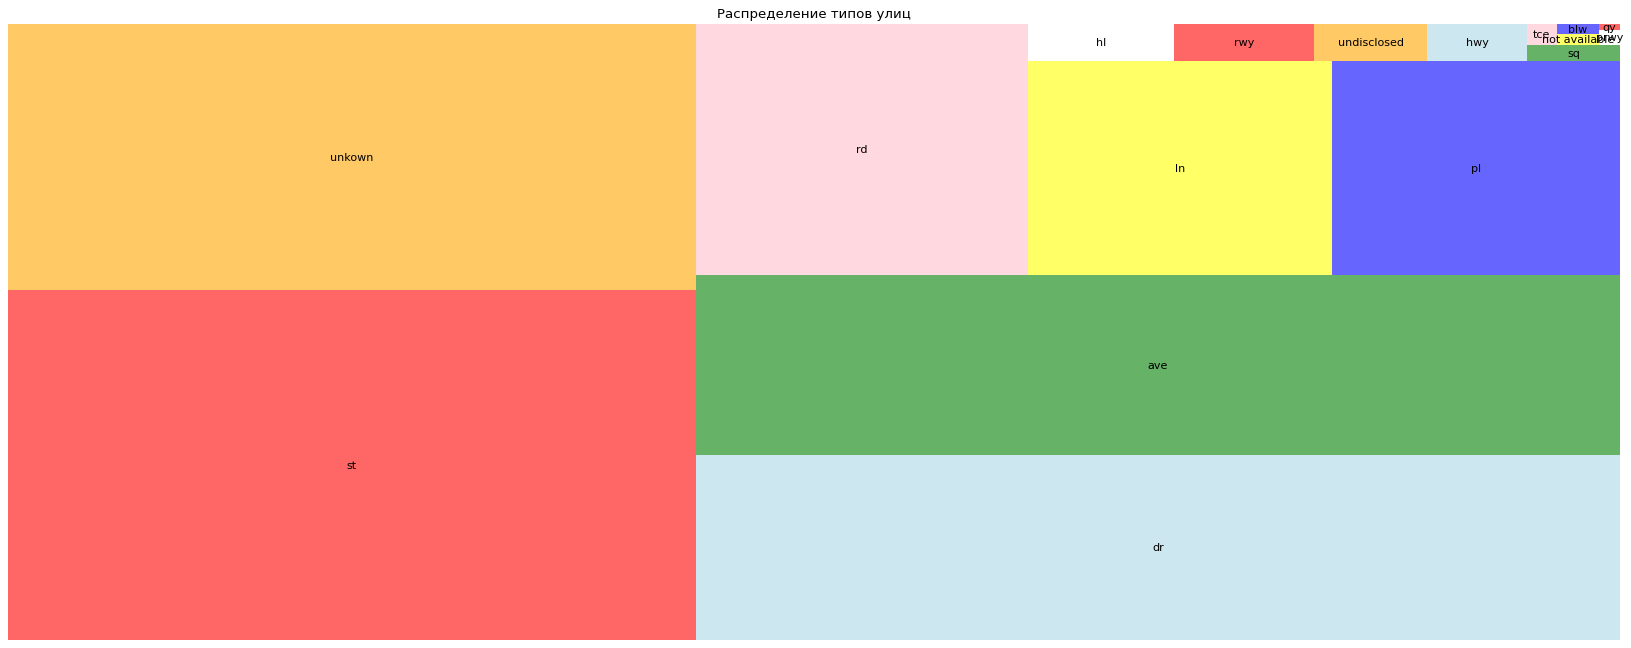

In [213]:
# строим древовидную диаграмму с рапределением стран проживания среди специалистов DS
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_street.values, label = data_street.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Распределение типов улиц')
plt.axis('off')
plt.show()

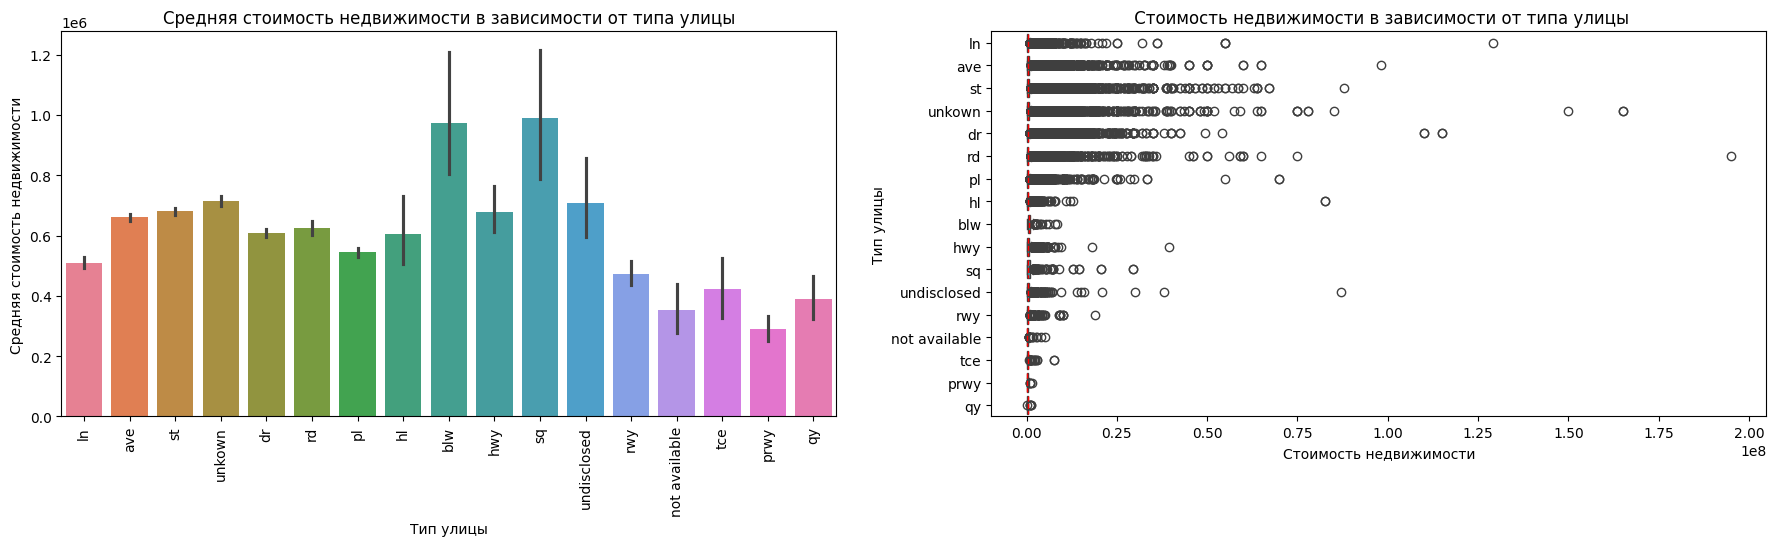

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от типа улицы
sns.barplot(
            data, 
            x='street', 
            y='target', 
            hue='street', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Тип улицы', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от типа улицы')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от типа улицы
sns.boxplot(
            data, 
            x='target', 
            y='street', 
            orient='h', 
            hue='street',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Тип улицы')
axes[1].set_title(' Стоимость недвижимости в зависимости от типа улицы')

plt.show()

Большинство адресов находятся на улицах, проспектах, проездах, а так же неизвестно. Самая высокая средняя стоимость у недвижимости, которая находится на бульварах и площадях. Самая низкая средняя стоимость у недвижимости, которая находится на тех типах улиц, что встречаются реже всего в данных - аллеи, набарежные и недостыпные адреса. Возможно это связано с маленьким количеством данных в этих категориях. Коробчатая диаграмма не дает возможности сделать какие-то выводы.

Закодируем признак street однократным кодированием (признак номинальный, количество значений не велико)

In [226]:
encoder = ce.OneHotEncoder(cols = ['street'], use_cat_names=True)
street_bin = encoder.fit_transform(data['street'])
data = pd.concat([data, type_bin], axis=1)

In [228]:
data = data.drop('street', axis = 1)

In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 377184
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                335049 non-null  object 
 1   propertyType          339752 non-null  object 
 2   baths                 269018 non-null  object 
 3   homeFacts             374306 non-null  object 
 4   city                  374306 non-null  object 
 5   schools               374306 non-null  object 
 6   sqft                  334195 non-null  object 
 7   beds                  283397 non-null  object 
 8   target                374306 non-null  float64
 9   street_ln             374306 non-null  int64  
 10  street_ave            374306 non-null  int64  
 11  street_st             374306 non-null  int64  
 12  street_unkown         374306 non-null  int64  
 13  street_dr             374306 non-null  int64  
 14  street_rd             374306 non-null  int64  
 15  stree

#### 3.4 Признаки state - штат и  city - город.

Как и в паре индекс-адрес, признаки штат и город сильно коррелируют друг с другом, так как определенные города расположены в определенных штатах. Оставлять оба признака не имеет смысла. Удалим признак state.

In [216]:
data = data.drop('state', axis=1)

In [217]:
# выведем статистику
data['city'].describe()

count      374272
unique       2019
top       Houston
freq        24388
Name: city, dtype: object

In [219]:
# посмотрим на распределение
data['city'].value_counts().nlargest(20)

city
Houston            24388
San Antonio        15496
Miami              15385
Jacksonville        9890
Dallas              8750
Brooklyn            7243
New York            6905
Chicago             6865
Charlotte           6517
Las Vegas           5959
Fort Worth          5474
Orlando             5156
Austin              5129
Fort Lauderdale     5072
Cleveland           5005
Nashville           4984
Philadelphia        4751
Tampa               4701
Washington          4581
Los Angeles         4151
Name: count, dtype: int64

In [220]:
data['city'].isnull().mean()*100

0.009083477155054956

Признак категориальный, заменим пропуски модой.

In [221]:
data['city'] = data['city'].fillna(data['city'].mode()[0])

Оставить все значения городов будет очень ресурсозатратно, поэтому выделим 20 наиболее часто встречающихся, остальные заменим на 'other'.

In [224]:
popular_city = data['city'].value_counts().nlargest(20).index
data['city'] = data['city'].apply(lambda x: x if x in popular_city else 'other')

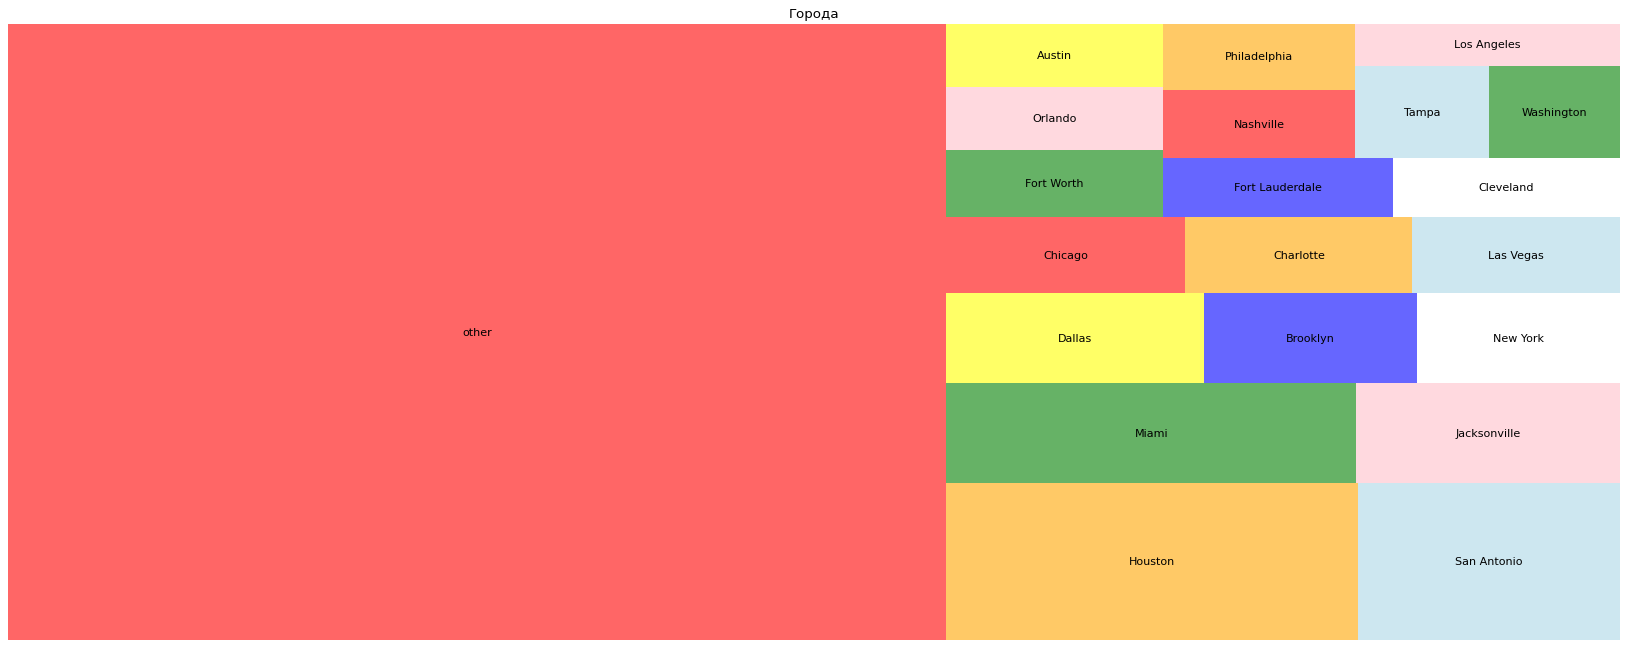

In [231]:
data_city = data.groupby('city')['city'].value_counts()
data_city = data_city.sort_values(ascending=False)
# строим древовидную диаграмму с рапределением городов, в которях находится недвижимость
plt.figure(figsize=(26,10), dpi= 80)
squarify.plot(sizes = data_city.values, label = data_city.index, alpha=.6, color = ['red','orange','lightblue','green','pink','yellow', 'blue', 'white'])

plt.title('Города')
plt.axis('off')
plt.show()

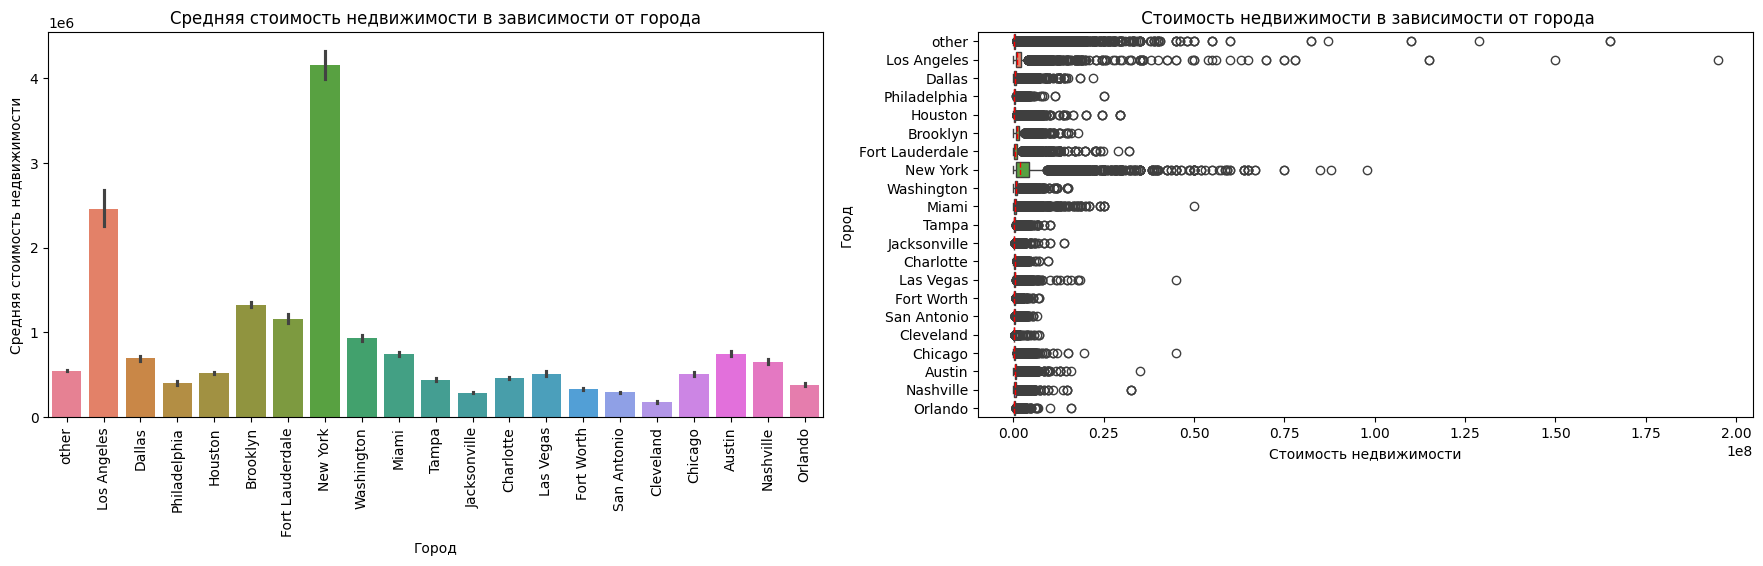

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Строим столбчатую диаграмму для визуализации средней стоимости недвижимости в зависимости от города
sns.barplot(
            data, 
            x='city', 
            y='target', 
            hue='city', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Город', ylabel='Средняя стоимость недвижимости')
axes[0].xaxis.set_tick_params(rotation = 90)
axes[0].set_title('Средняя стоимость недвижимости в зависимости от города')

# Строим коробчатую диаграмму для визуализации стоимости недвижимости в зависимости от города
sns.boxplot(
            data, 
            x='target', 
            y='city', 
            orient='h', 
            hue='city',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Стоимость недвижимости', ylabel='Город')
axes[1].set_title(' Стоимость недвижимости в зависимости от города')

plt.show()

Очевидно, что самая высокая стоимость недвижимости будет в самых крупных и дороших городах - Нью-Йорке и Лос-Анджелесе.

Закодируем признак city однократным кодированием (признак номинальный, количество значений не велико)

In [233]:
encoder = ce.OneHotEncoder(cols = ['city'], use_cat_names=True)
city_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, city_bin], axis=1)

In [234]:
data = data.drop('city', axis = 1)

#### 3.5 Признак beds - количество спален.

### 4. Решение задачи регрессии.

In [215]:
#sns.pairplot(data)

#### 4.1 Линейная регрессия.

#### 4.2 Дерево решений.

#### 4.3 Случайный лес

#### 4.3 Градиентыный бустинг

#### 4.3 Cat бустинг